# CS295RL Mini-project
## Reyes, Marcus
## 2015-89006

Dependencies are torch and gym with the following versions
Directories are not needed since data is generated and used without saving.
Figures and final weights of the networks will be saved in the same directory as the notebook

In [58]:
import sys
print(gym.__version__)
print(sys.version)
print(torch.__version__)

0.21.0
3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
1.10.1


In [1]:
from collections import deque, namedtuple
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import math
#Imports for env creation
#import gym
from gym import spaces
from gym import Env
from gym.utils import seeding
#import numpy as np
#from typing import Optional

#For plotting
import matplotlib.pyplot as plt


import gym
#import ale_py
import torch
from matplotlib import pyplot as plt

#Template used https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html


In [3]:
def state_to_tensor(state):
    state_tensor = torch.tensor(state, dtype = torch.float32)
    return state_tensor.unsqueeze(dim = 0)

#Since this uses plt.plot Kindly use it in its own box
def plot_mov_avg(inputlist):
    mov_avg = np.array([])
    for i in range(4000):
        avg = sum(inputlist[i:i+1000])/len(inputlist[i:i+1000])
        mov_avg = np.append(mov_avg, avg)
    plt.plot(mov_avg)
    
def save_mov_avg(inputlist, name, mytitle):
    mov_avg = np.array([])
    for i in range(4000):
        avg = sum(inputlist[i:i+1000])/len(inputlist[i:i+1000])
        mov_avg = np.append(mov_avg, avg)
    plt.plot(mov_avg)
    plt.title(mytitle)
    plt.savefig(name)

In [4]:
Transition = namedtuple('Transition',
                       ('state', 'action', 'next_state', 'reward'))

#From pytorch dqn tutorial
class ReplayMemory():
    
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)
        
    def push(self, *args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [5]:
class DQNNet(nn.Module):
    
    def __init__(self, dim_list, output_size = 13):
        
        super(DQNNet, self).__init__()
        
        self.conv_list = nn.ModuleList()
        self.bn_list = nn.ModuleList()
        
        #format is [input size, dim1, dim2, dim3, etc.] output not included
        self.dim_list = dim_list
        self.output_size = 13

        for i, item in enumerate(self.dim_list):
            if i == len(self.dim_list)-1:
                #Skip the last iteration because the output will be different
                break
            self.conv_list.append(nn.Conv2d(self.dim_list[i], \
                                            self.dim_list[i+1], \
                                           (3,3),\
                                           ))
            self.bn_list.append(nn.BatchNorm1d(self.dim_list[i+1]))
            
        #Hardcode the final layer
        self.final_layer = nn.Linear(64*9*9, output_size)

        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.device = device
        self.to(self.device)
        
    def forward(self, x):
        for i, item in enumerate(self.dim_list):
            if i == len(self.dim_list) -1:
                break
            x = self.conv_list[i](x)
            #no batch norm because we process one at a time
            #x = self.bn_list[i](x)
            x = F.relu(x)
        x = x.reshape(x.shape[0], -1)
        x = self.final_layer(x)
        x = nn.Softmax(dim = 1)(x)
        return x

In [6]:
#Test that the qnet input outputs are working
q_net = DQNNet([6, 32, 64], 13)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
dummy_in = torch.rand((2, 6, 13, 13)).to(device)
out = q_net.forward(dummy_in)

print(out)
out[0].argmax() + 1
print(out[0].topk(13)[1])

tensor([[0.0776, 0.0816, 0.0724, 0.0831, 0.0828, 0.0824, 0.0745, 0.0717, 0.0702,
         0.0800, 0.0752, 0.0776, 0.0709],
        [0.0792, 0.0748, 0.0687, 0.0868, 0.0829, 0.0816, 0.0724, 0.0730, 0.0726,
         0.0793, 0.0769, 0.0773, 0.0744]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([ 3,  4,  5,  1,  9,  0, 11, 10,  6,  2,  7, 12,  8], device='cuda:0')


In [7]:
class GOPSEnv(Env):

    def __init__(self):
        
        #Most of initialization actually done in reset()
        num_actions = 13
        self.action_space = spaces.Discrete(num_actions)

    def step(self, a):
        
        #hardcoded for playing manually. Only ever input a tuple if you want to input a_e too
        inita = a
        if isinstance(inita, tuple):
            a = a[0]
        hp = int(np.count_nonzero(self.s[0][5])/13)-1 #because it start with 1's at first round indicator
        
        
        #Check if valid action
        if self.s[0][0,:,a-1].any() == 1:
            #No longer applicable after the ruling out of invalid actions was implemented so this should never happen
            print("Invalid action This should never have been reached")
            self.s = None
            #reward = -10
            reward = -1
            done = True
            info = "Tried to play a card already played"
            return self.s, reward, done, info
        
        ###Get enemy action
        if self.enemy_strat == 'match':
            a_e = self.s[-1] #Take the prize card as your action
        if self.enemy_strat == 'oneunder':
            a_e = self.s[-1]-1 #Take the prize card-1 as your action
            if a_e == 0:
                a_e = 13
        if self.enemy_strat == 'oneover':
            a_e = self.s[-1]+1 #Take the prize card+1 as your action
            if a_e == 14:
                a_e = 1
        if self.enemy_strat == 'random':
            a_e = np.random.choice(13,1)[0]+1
            #While it is in hands played pick another one
            while self.s[0][1,:,a_e-1].any() == 1:
                a_e = np.random.choice(13,1)[0]+1
        
        if isinstance(inita, tuple):
            a_e = inita[1]
            print("Manual play. The user chose to play {}. The AI chose to play {}. The prize card is {}".format(a_e, a, self.s[-1]))
        
        
        ### Get reward and next state
        #Sometimes I used pc sometimes s[-1] at this point i'm too afraid to rerun it if one bugs out. But in theory those should be the same.
        if a > a_e:
            css = self.s[-1]
            cse = 0
            reward = css/91
            idx_won = 3
        elif a_e > a:
            css = 0
            cse = self.s[-1]
            reward = -cse/91
            idx_won = 4
        elif a_e == a:
            css = ((self.pc[hp])+1)/2
            cse = ((self.pc[hp])+1)/2
            #reward = (((self.pc[hp])+1)/2)/45
            reward = 0 #since we just tie
            idx_won = (3,4)
        
        ###Get done info and return empty tuple as state if so
        ###when 12 hands have been played. and you take an action then the game will be done
        ###Might have to change later
        if hp == 12:
            done = True
            main_state = self.s[0]
            main_state[0,hp, a-1] = 1
            main_state[1,hp, a_e-1] = 1
            #main_state[2,hp+1,self.pc[hp+1]] = 1
            main_state[idx_won,hp,:] = 1
            #main_state[5,hp+1,:] = 1
            self.s[1][hp] = a
            self.s[2][hp] = a_e
            #self.s[2] += css
            #self.s[3] += cse
            #self.s[4] = self.pc[hp + 1]
            self.s = (
                    main_state,\
                    self.s[1],\
                    self.s[2],\
                    self.s[3] + css,\
                    self.s[4] + cse,\
                    0
                )
            if self.s[3] + css > self.s[4] + cse:
                reward = 1
            else:
                reward = -1
                
            self.s = None #I think this has to be None to indicate the end
        
        else:
            done = False
            main_state = self.s[0]
            main_state[0,hp, a-1] = 1
            main_state[1,hp, a_e-1] = 1
            main_state[2,hp+1,self.pc[hp+1]] = 1
            main_state[idx_won,hp,:] = 1
            main_state[5,hp+1,:] = 1
            self.s[1][hp] = a
            self.s[2][hp] = a_e
            #self.s[2] += css
            #self.s[3] += cse
            #self.s[4] = self.pc[hp + 1]
            self.s = (
                    main_state,\
                    self.s[1],\
                    self.s[2],\
                    self.s[3] + css,\
                    self.s[4] + cse,\
                    self.pc[hp+1]+1\
                )
        info = "none"

        return self.s, reward, done, info

    def reset(
        self,
        *,
        enemy_strat = 'match',
    ):
        
        self.pc = np.random.choice(13, 13, replace = False)
        
        self.enemy_strat = enemy_strat
        
        #13*13 cards played self
        #13*13 cards played enemy
        #13*13 prize card hide unplayed
        
        #for the following a row of 1's each
        #13*13 rounds won self
        #13*13 rounds won enemy
        #13*13 current round being played 
        
        #these 3 are for info/debugging
        #css current score self
        #cse current score enemy
        #cpc current prize card
                   
        main_state = np.zeros((6,13,13))
                   
        #main_state[plane][round][index of value (i.e. index 0 means card one was played)]
        main_state[2,0,self.pc[0]] = 1
        main_state[5,0,:] = 1
        self.s = (
            main_state,\
            [0,0,0,0,0,0,0,0,0,0,0,0,0],\
            [0,0,0,0,0,0,0,0,0,0,0,0,0],\
            0, \
            0, \
            self.pc[0]+1
            
        )
        return self.s

In [8]:
gym.envs.register(
     id='GOPS-v0',
     entry_point='__main__:GOPSEnv',
)


# Statistics for Newly Initialized networks versus deterministic strategies

In [9]:

env = gym.make('GOPS-v0')
strategy_list = ['random', 'oneunder', 'oneover', 'match']
wins_list = []
for strategy in strategy_list:
    wins = 0
    print("Testing strategy: {}".format(strategy))
    for i in range(30):
        p_net = DQNNet([6, 32, 64], 13)
        test_game_num = 500
        invalid_attempt = 0
        for game_num in range(test_game_num):
            if (game_num+1)%1000 == 0:
                #print("Game {}".format(game_num))
                pass
            #play a sample game
            state = env.reset(enemy_strat = strategy)
            cards_played_self = state[-5]
            pc = state[-1]
            state = state[0]

            reward_per_game = 0
            device = "cuda:0" if torch.cuda.is_available() else "cpu"
            state_inp = state_to_tensor(state).to(device)
            #print(state_inp)
            for i in range(13):
                with torch.no_grad():
                    out = p_net.forward(state_inp)
                    action = (out[0].argmax() + 1).item()
                    idx_topk = 1
                    while action in cards_played_self:
                        invalid_attempt += 1
                        action = (out[0].topk(13)[1][idx_topk]+1).item()
                        idx_topk += 1
                #print("Selecting {} as the action for card{}".format(action, pc))

                next_state, reward, done, info = env.step(action)
                #print("state is now:", next_state)
                try:
                    pc = next_state[-1]
                    state = next_state[0]
                    state_inp = state_to_tensor(state).to(device)
                except:
                    pass
                    #print("Done state")

                if reward == 1:
                    wins += 1
                elif reward == -1:
                    pass
    wins_list.append(wins)

Testing strategy: random
Testing strategy: oneunder
Testing strategy: oneover
Testing strategy: match


In [10]:
for item in wins_list:
    print(item/15000)
'''
0.4814 random
0.0602 match
0.1474 one over
0.1776 one under
'''

0.4892
0.1818
0.1328
0.04713333333333333


'\n0.4814 random\n0.0602 match\n0.1474 one over\n0.1776 one under\n'

# Random Training

In [11]:
env = gym.make('GOPS-v0')
memory = ReplayMemory(10000)


exp_num = 1
gamma = 0.99
batch_size = 512
update_period = 50
eps_start = 0.9
eps_end = 0.05
eps_decay = 200

select_action_steps_counter = 0

q_net = DQNNet([6, 32, 64], 13)
p_net = DQNNet([6, 32, 64], 13)
optimizer = optim.Adam(p_net.parameters(), lr = 0.0005)
#Tutorial Template:https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

###Debugging variables
batch_list = []
loss_list = []
avg_loss_list = []
max_episodes = 5000
won_cnt = 0
loss_cnt = 0
won_games = []
reward_per_episode_list = []
for ep_num in range(max_episodes):
    if ep_num % 500 == 0:
        print("Starting episode {}".format(ep_num))
    init_state = env.reset(enemy_strat = 'random')
    cards_played_self = init_state[-5]
    init_state = init_state[0] #obtain only the numpy array

    init_state_inp = state_to_tensor(init_state)
    done = False


    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    state = init_state_inp
    reward_per_episode = 0
    while done != True:

        state = state.to(device)
        
        #Select action with exploration allowed
        sample = random.random()
        eps_treshold = eps_end + (eps_start - eps_end) * math.exp(-1. * select_action_steps_counter/eps_decay)
        
        select_action_steps_counter += 1
        if sample > eps_treshold:
            with torch.no_grad():
                out = p_net.forward(state)
                action = (out[0].argmax() + 1).item()
            idx_topk = 1
            while action in cards_played_self:
                action = (out[0].topk(13)[1][idx_topk]+1).item()
                idx_topk += 1
        else:
            action = random.randrange(13)+1
            while action in cards_played_self:
                action = random.randrange(13)+1
        
        
        next_state, reward, done, info = env.step(action)
        reward_per_episode += reward
        if reward == 1:
            won_cnt += 1
            won_games.append(1)
            reward_per_episode_list.append(reward_per_episode)
            reward_per_episode = 0
        elif reward == -1:
            loss_cnt += 1
            won_games.append(0)
            reward_per_episode_list.append(reward_per_episode)
            reward_per_episode = 0
        try:
            next_state = next_state[0] #obtain only the numpy array

            next_state = state_to_tensor(next_state)

            if isinstance(next_state, tuple):
                #print(next_state)
                pass
        except:
            pass
            #print("none type just pushing")
        
        memory.push(state,\
                    torch.tensor(action).view(1,1).to(device), \
                    next_state, \
                    torch.tensor(reward).view(1,1).to(device))
        
        #Update state for next run
        state = next_state
        
        #Optimize once
        if len(memory) < batch_size:
            pass
        else:
            transitions = memory.sample(batch_size)
            
            #pytorch tutorial doing magic manipulation
            batch = Transition(*zip(*transitions))
            batch_list.append(batch)
            
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,\
                                                   batch.next_state)), device = device,\
                                                   dtype = torch.bool)

            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
            
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            action_batch = action_batch - 1 #if you play action 13 it's iindex 12
            reward_batch = torch.cat(batch.reward)
            
            state_action_values = p_net(state_batch).gather(1, action_batch)
            
            
            next_state_values = torch.zeros(batch_size).to(device)
            
            next_state_values[non_final_mask] = q_net(non_final_next_states).max(1)[0].detach()
            next_state_values = next_state_values.view(next_state_values.shape[0], -1)
            
            expected_state_action_values = (next_state_values * gamma) + reward_batch
            
            
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_state_action_values)
            
            optimizer.zero_grad()
            loss.backward()
               
            optimizer.step()
            
        if done == True:
            break
    if ep_num % update_period == 0:
        q_net.load_state_dict(p_net.state_dict())

Starting episode 0
Starting episode 500
Starting episode 1000
Starting episode 1500
Starting episode 2000
Starting episode 2500
Starting episode 3000
Starting episode 3500
Starting episode 4000
Starting episode 4500


In [12]:
#Save the net
p_random = DQNNet([6, 32, 64], 13)
p_random.load_state_dict(p_net.state_dict()) 
random_reward_per_episode_list = reward_per_episode_list.copy()
random_won_games = won_games.copy()

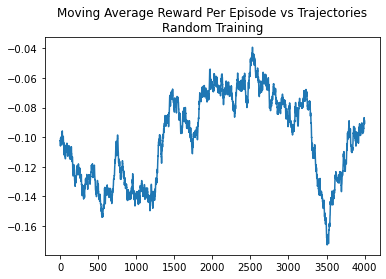

In [13]:
save_mov_avg(random_reward_per_episode_list,"rand_rew.png","Moving Average Reward Per Episode vs Trajectories\nRandom Training")

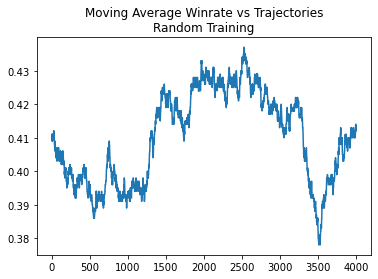

In [14]:
save_mov_avg(random_won_games,"rand_wr.png","Moving Average Winrate vs Trajectories\nRandom Training")

In [15]:
print("DONE")

DONE


# One Under Training

In [16]:
env = gym.make('GOPS-v0')
memory = ReplayMemory(10000)


exp_num = 1
gamma = 0.99
batch_size = 512
update_period = 50
eps_start = 0.9
eps_end = 0.05
eps_decay = 200

select_action_steps_counter = 0

q_net = DQNNet([6, 32, 64], 13)
p_net = DQNNet([6, 32, 64], 13)
optimizer = optim.Adam(p_net.parameters(), lr = 0.0005)
#Tutorial Template:https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

###Debugging variables
batch_list = []
loss_list = []
avg_loss_list = []
max_episodes = 5000
won_cnt = 0
loss_cnt = 0
won_games = []
reward_per_episode_list = []
for ep_num in range(max_episodes):
    if ep_num % 500 == 0:
        print("Starting episode {}".format(ep_num))
    init_state = env.reset(enemy_strat = 'oneunder')
    cards_played_self = init_state[-5]
    init_state = init_state[0] #obtain only the numpy array

    init_state_inp = state_to_tensor(init_state)
    done = False


    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    state = init_state_inp
    reward_per_episode = 0
    while done != True:

        state = state.to(device)
        
        #Select action with exploration allowed
        sample = random.random()
        eps_treshold = eps_end + (eps_start - eps_end) * math.exp(-1. * select_action_steps_counter/eps_decay)
        
        select_action_steps_counter += 1
        if sample > eps_treshold:
            with torch.no_grad():
                out = p_net.forward(state)
                action = (out[0].argmax() + 1).item()
            idx_topk = 1
            while action in cards_played_self:
                action = (out[0].topk(13)[1][idx_topk]+1).item()
                idx_topk += 1
        else:
            action = random.randrange(13)+1
            while action in cards_played_self:
                action = random.randrange(13)+1
        
        
        next_state, reward, done, info = env.step(action)
        reward_per_episode += reward
        if reward == 1:
            won_cnt += 1
            won_games.append(1)
            reward_per_episode_list.append(reward_per_episode)
            reward_per_episode = 0
        elif reward == -1:
            loss_cnt += 1
            won_games.append(0)
            reward_per_episode_list.append(reward_per_episode)
            reward_per_episode = 0
        try:
            next_state = next_state[0] #obtain only the numpy array

            next_state = state_to_tensor(next_state)

            if isinstance(next_state, tuple):
                #print(next_state)
                pass
        except:
            pass
            #print("none type just pushing")
        
        memory.push(state,\
                    torch.tensor(action).view(1,1).to(device), \
                    next_state, \
                    torch.tensor(reward).view(1,1).to(device))
        
        #Update state for next run
        state = next_state
        
        #Optimize once
        if len(memory) < batch_size:
            pass
        else:
            transitions = memory.sample(batch_size)
            
            #pytorch tutorial doing magic manipulation
            batch = Transition(*zip(*transitions))
            batch_list.append(batch)
            
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,\
                                                   batch.next_state)), device = device,\
                                                   dtype = torch.bool)

            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
            
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            action_batch = action_batch - 1 #if you play action 13 it's iindex 12
            reward_batch = torch.cat(batch.reward)
            
            state_action_values = p_net(state_batch).gather(1, action_batch)
            
            
            next_state_values = torch.zeros(batch_size).to(device)
            
            next_state_values[non_final_mask] = q_net(non_final_next_states).max(1)[0].detach()
            next_state_values = next_state_values.view(next_state_values.shape[0], -1)
            
            expected_state_action_values = (next_state_values * gamma) + reward_batch
            
            
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_state_action_values)
            
            optimizer.zero_grad()
            loss.backward()
               
            optimizer.step()
            
        if done == True:
            break
    if ep_num % update_period == 0:
        q_net.load_state_dict(p_net.state_dict())

Starting episode 0
Starting episode 500
Starting episode 1000
Starting episode 1500
Starting episode 2000
Starting episode 2500
Starting episode 3000
Starting episode 3500
Starting episode 4000
Starting episode 4500


In [17]:

p_oneunder = DQNNet([6, 32, 64], 13)
p_oneunder.load_state_dict(p_net.state_dict()) 
oneunder_reward_per_episode_list = reward_per_episode_list.copy()
oneunder_won_games = won_games.copy()

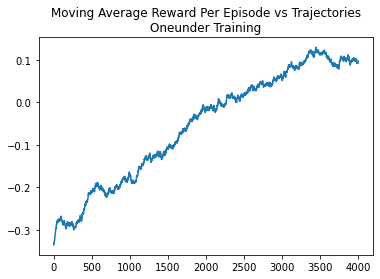

In [18]:
save_mov_avg(oneunder_reward_per_episode_list,"oneunder_rew.png","Moving Average Reward Per Episode vs Trajectories\nOneunder Training")

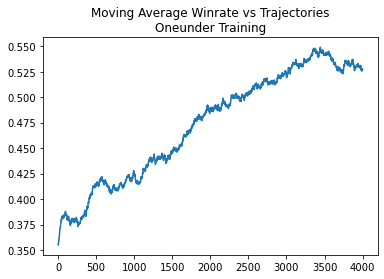

In [19]:
save_mov_avg(oneunder_won_games,"oneunder_wr.png","Moving Average Winrate vs Trajectories\nOneunder Training")

# Oneover Training

In [20]:
env = gym.make('GOPS-v0')
memory = ReplayMemory(10000)


exp_num = 1
gamma = 0.99
batch_size = 512
update_period = 50
eps_start = 0.9
eps_end = 0.05
eps_decay = 200

select_action_steps_counter = 0

q_net = DQNNet([6, 32, 64], 13)
p_net = DQNNet([6, 32, 64], 13)
optimizer = optim.Adam(p_net.parameters(), lr = 0.0005)
#Tutorial Template:https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

###Debugging variables
batch_list = []
loss_list = []
avg_loss_list = []
max_episodes = 5000
won_cnt = 0
loss_cnt = 0
won_games = []
reward_per_episode_list = []
for ep_num in range(max_episodes):
    if ep_num % 500 == 0:
        print("Starting episode {}".format(ep_num))
    init_state = env.reset(enemy_strat = 'oneover')
    cards_played_self = init_state[-5]
    init_state = init_state[0] #obtain only the numpy array

    init_state_inp = state_to_tensor(init_state)
    done = False


    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    state = init_state_inp
    reward_per_episode = 0
    while done != True:

        state = state.to(device)
        
        #Select action with exploration allowed
        sample = random.random()
        eps_treshold = eps_end + (eps_start - eps_end) * math.exp(-1. * select_action_steps_counter/eps_decay)
        
        select_action_steps_counter += 1
        if sample > eps_treshold:
            with torch.no_grad():
                out = p_net.forward(state)
                action = (out[0].argmax() + 1).item()
            idx_topk = 1
            while action in cards_played_self:
                action = (out[0].topk(13)[1][idx_topk]+1).item()
                idx_topk += 1
        else:
            action = random.randrange(13)+1
            while action in cards_played_self:
                action = random.randrange(13)+1
        
        
        next_state, reward, done, info = env.step(action)
        reward_per_episode += reward
        if reward == 1:
            won_cnt += 1
            won_games.append(1)
            reward_per_episode_list.append(reward_per_episode)
            reward_per_episode = 0
        elif reward == -1:
            loss_cnt += 1
            won_games.append(0)
            reward_per_episode_list.append(reward_per_episode)
            reward_per_episode = 0
        try:
            next_state = next_state[0] #obtain only the numpy array

            next_state = state_to_tensor(next_state)

            if isinstance(next_state, tuple):
                #print(next_state)
                pass
        except:
            pass
            #print("none type just pushing")
        
        memory.push(state,\
                    torch.tensor(action).view(1,1).to(device), \
                    next_state, \
                    torch.tensor(reward).view(1,1).to(device))
        
        #Update state for next run
        state = next_state
        
        #Optimize once
        if len(memory) < batch_size:
            pass
        else:
            transitions = memory.sample(batch_size)
            
            #pytorch tutorial doing magic manipulation
            batch = Transition(*zip(*transitions))
            batch_list.append(batch)
            
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,\
                                                   batch.next_state)), device = device,\
                                                   dtype = torch.bool)

            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
            
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            action_batch = action_batch - 1 #if you play action 13 it's iindex 12
            reward_batch = torch.cat(batch.reward)
            
            state_action_values = p_net(state_batch).gather(1, action_batch)
            
            
            next_state_values = torch.zeros(batch_size).to(device)
            
            next_state_values[non_final_mask] = q_net(non_final_next_states).max(1)[0].detach()
            next_state_values = next_state_values.view(next_state_values.shape[0], -1)
            
            expected_state_action_values = (next_state_values * gamma) + reward_batch
            
            
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_state_action_values)
            
            optimizer.zero_grad()
            loss.backward()
               
            optimizer.step()
            
        if done == True:
            break
    if ep_num % update_period == 0:
        q_net.load_state_dict(p_net.state_dict())

Starting episode 0
Starting episode 500
Starting episode 1000
Starting episode 1500
Starting episode 2000
Starting episode 2500
Starting episode 3000
Starting episode 3500
Starting episode 4000
Starting episode 4500


In [21]:

p_oneover = DQNNet([6, 32, 64], 13)
p_oneover.load_state_dict(p_net.state_dict()) 
oneover_reward_per_episode_list = reward_per_episode_list.copy()
oneover_won_games = won_games.copy()

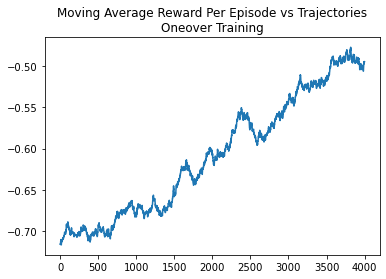

In [22]:
save_mov_avg(oneover_reward_per_episode_list,"oneover_rew.png","Moving Average Reward Per Episode vs Trajectories\nOneover Training")

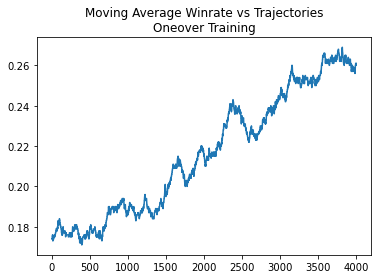

In [23]:
save_mov_avg(oneover_won_games,"oneover_wr.png","Moving Average Winrate vs Trajectories\nOneover Training")

# Match Training

In [24]:
env = gym.make('GOPS-v0')
memory = ReplayMemory(10000)


exp_num = 1
gamma = 0.99
batch_size = 512
update_period = 50
eps_start = 0.9
eps_end = 0.05
eps_decay = 200

select_action_steps_counter = 0

q_net = DQNNet([6, 32, 64], 13)
p_net = DQNNet([6, 32, 64], 13)
optimizer = optim.Adam(p_net.parameters(), lr = 0.0005)
#Tutorial Template:https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

###Debugging variables
batch_list = []
loss_list = []
avg_loss_list = []
max_episodes = 5000
won_cnt = 0
loss_cnt = 0
won_games = []
reward_per_episode_list = []
for ep_num in range(max_episodes):
    if ep_num % 500 == 0:
        print("Starting episode {}".format(ep_num))
    init_state = env.reset(enemy_strat = 'match')
    cards_played_self = init_state[-5]
    init_state = init_state[0] #obtain only the numpy array

    init_state_inp = state_to_tensor(init_state)
    done = False


    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    state = init_state_inp
    reward_per_episode = 0
    while done != True:

        state = state.to(device)
        
        #Select action with exploration allowed
        sample = random.random()
        eps_treshold = eps_end + (eps_start - eps_end) * math.exp(-1. * select_action_steps_counter/eps_decay)
        
        select_action_steps_counter += 1
        if sample > eps_treshold:
            with torch.no_grad():
                out = p_net.forward(state)
                action = (out[0].argmax() + 1).item()
            idx_topk = 1
            while action in cards_played_self:
                action = (out[0].topk(13)[1][idx_topk]+1).item()
                idx_topk += 1
        else:
            action = random.randrange(13)+1
            while action in cards_played_self:
                action = random.randrange(13)+1
        
        
        next_state, reward, done, info = env.step(action)
        reward_per_episode += reward
        if reward == 1:
            won_cnt += 1
            won_games.append(1)
            reward_per_episode_list.append(reward_per_episode)
            reward_per_episode = 0
        elif reward == -1:
            loss_cnt += 1
            won_games.append(0)
            reward_per_episode_list.append(reward_per_episode)
            reward_per_episode = 0
        try:
            next_state = next_state[0] #obtain only the numpy array

            next_state = state_to_tensor(next_state)

            if isinstance(next_state, tuple):
                #print(next_state)
                pass
        except:
            pass
            #print("none type just pushing")
        
        memory.push(state,\
                    torch.tensor(action).view(1,1).to(device), \
                    next_state, \
                    torch.tensor(reward).view(1,1).to(device))
        
        #Update state for next run
        state = next_state
        
        #Optimize once
        if len(memory) < batch_size:
            pass
        else:
            transitions = memory.sample(batch_size)
            
            #pytorch tutorial doing magic manipulation
            batch = Transition(*zip(*transitions))
            batch_list.append(batch)
            
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,\
                                                   batch.next_state)), device = device,\
                                                   dtype = torch.bool)

            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
            
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            action_batch = action_batch - 1 #if you play action 13 it's iindex 12
            reward_batch = torch.cat(batch.reward)
            
            state_action_values = p_net(state_batch).gather(1, action_batch)
            
            
            next_state_values = torch.zeros(batch_size).to(device)
            
            next_state_values[non_final_mask] = q_net(non_final_next_states).max(1)[0].detach()
            next_state_values = next_state_values.view(next_state_values.shape[0], -1)
            
            expected_state_action_values = (next_state_values * gamma) + reward_batch
            
            
            criterion = nn.SmoothL1Loss()
            loss = criterion(state_action_values, expected_state_action_values)
            
            optimizer.zero_grad()
            loss.backward()
               
            optimizer.step()
            
        if done == True:
            break
    if ep_num % update_period == 0:
        q_net.load_state_dict(p_net.state_dict())

Starting episode 0
Starting episode 500
Starting episode 1000
Starting episode 1500
Starting episode 2000
Starting episode 2500
Starting episode 3000
Starting episode 3500
Starting episode 4000
Starting episode 4500


In [25]:

p_match = DQNNet([6, 32, 64], 13)
p_match.load_state_dict(p_net.state_dict()) 
match_reward_per_episode_list = reward_per_episode_list.copy()
match_won_games = won_games.copy()

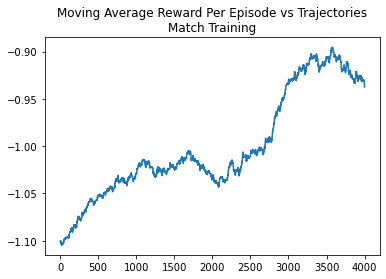

In [26]:
save_mov_avg(match_reward_per_episode_list,"match_rew.png","Moving Average Reward Per Episode vs Trajectories\nMatch Training")

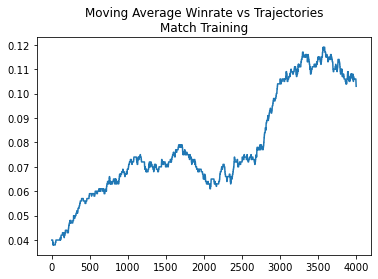

In [27]:
save_mov_avg(match_won_games,"match_wr.png","Moving Average Winrate vs Trajectories\nMatch Training")

# Further Statistics

In [28]:

env = gym.make('GOPS-v0')
strategy_list = ['random', 'oneunder', 'oneover', 'match']
p_nets = [p_random, p_oneunder, p_oneover, p_match]
wins_list = []
for strat_idx, strategy in enumerate(strategy_list):
    wins = 0
    print("Testing strategy: {}".format(strategy))
    for i in range(1):
        p_net = p_nets[strat_idx]
        test_game_num = 500*30
        invalid_attempt = 0
        for game_num in range(test_game_num):
            if (game_num+1)%1000 == 0:
                #print("Game {}".format(game_num))
                pass
            #play a sample game
            state = env.reset(enemy_strat = strategy)
            cards_played_self = state[-5]
            pc = state[-1]
            state = state[0]

            reward_per_game = 0
            device = "cuda:0" if torch.cuda.is_available() else "cpu"
            state_inp = state_to_tensor(state).to(device)
            #print(state_inp)
            for i in range(13):
                with torch.no_grad():
                    out = p_net.forward(state_inp)
                    action = (out[0].argmax() + 1).item()
                    idx_topk = 1
                    while action in cards_played_self:
                        invalid_attempt += 1
                        action = (out[0].topk(13)[1][idx_topk]+1).item()
                        idx_topk += 1
                #print("Selecting {} as the action for card{}".format(action, pc))

                next_state, reward, done, info = env.step(action)
                #print("state is now:", next_state)
                try:
                    pc = next_state[-1]
                    state = next_state[0]
                    state_inp = state_to_tensor(state).to(device)
                except:
                    pass
                    #print("Done state")

                if reward == 1:
                    wins += 1
                elif reward == -1:
                    pass
    wins_list.append(wins)

Testing strategy: random
Testing strategy: oneunder
Testing strategy: oneover
Testing strategy: match


In [29]:
for item in wins_list:
    print(item/15000)

0.4162666666666667
0.5706666666666667
0.27873333333333333
0.10273333333333333


# Playing against an agent



In [46]:
torch.save(p_random.state_dict(), "p_random.pt")
torch.save(p_oneover.state_dict(), "p_oneover.pt")
torch.save(p_oneunder.state_dict(), "p_oneunder.pt")
torch.save(p_match.state_dict(), "p_match.pt")

In [50]:
play_net = p_match

#repalce with p_match, p_oneunder, p_oneover as desired

In [55]:

env = gym.make('GOPS-v0')
test_game_num = 500
invalid_attempt = 0

state = env.reset(enemy_strat = 'random') #enemy strat does not matter since we will override it
cards_played_self = state[-5]
cards_played_human = state[-4] #a bit confusing but you are not self. you are human. self is the agent referring to itself
pc = state[-1]
state = state[0]

reward_per_game = 0
device = "cuda:0" if torch.cuda.is_available() else "cpu"
state_inp = state_to_tensor(state).to(device)
#print(state_inp)
for i in range(13):
    print("------------------------------------")
    print("Prize card for round {} is {}".format(i, pc))
    your_move = int(input("Enter your move: 1-13: "))
    while your_move in cards_played_human:
        print("Invalid Move. Choose again.")
        your_move = int(input("Enter your move: 1-13: "))
        
    with torch.no_grad():
        out = play_net.forward(state_inp)
        action = (out[0].argmax() + 1).item()
        idx_topk = 1
        while action in cards_played_self:
            print("AI Attempted {}".format(action))
            invalid_attempt += 1
            action = (out[0].topk(13)[1][idx_topk]+1).item()
            idx_topk += 1
    #print("Selecting {} as the action for card{}".format(action, pc))

    action = (action, your_move)
    next_state, reward, done, info = env.step(action)
    #print("state is now:", next_state)
    try:
        aiscore = next_state[-3]
        humanscore = next_state[-2]
        print("Current score is Human:{} vs AI:{}".format(humanscore,aiscore))
        pc = next_state[-1]
        state = next_state[0]
        state_inp = state_to_tensor(state).to(device)
    except:
        pass
        #print("Done state")

    if reward == 1:
        wins += 1
    elif reward == -1:
        pass
    if i == 12:
        if action[0] > action[1]:
            print("Final score is Human:{} vs AI:{}".format(humanscore,aiscore+pc))
        else:
            print("Final score is Human:{} vs AI:{}".format(humanscore+pc,aiscore))

------------------------------------
Prize card for round 0 is 8
Enter your move: 1-13: 1
Manual play. The user chose to play 1. The AI chose to play 13. The prize card is 8
Current score is Human:0 vs AI:8
------------------------------------
Prize card for round 1 is 13
Enter your move: 1-13: 13
Manual play. The user chose to play 13. The AI chose to play 3. The prize card is 13
Current score is Human:13 vs AI:8
------------------------------------
Prize card for round 2 is 3
Enter your move: 1-13: 2
Manual play. The user chose to play 2. The AI chose to play 4. The prize card is 3
Current score is Human:13 vs AI:11
------------------------------------
Prize card for round 3 is 11
Enter your move: 1-13: 12
Manual play. The user chose to play 12. The AI chose to play 2. The prize card is 11
Current score is Human:24 vs AI:11
------------------------------------
Prize card for round 4 is 4
Enter your move: 1-13: 3
Manual play. The user chose to play 3. The AI chose to play 6. The prize